# Introduction to Gradient Boosting

## Prerequisites

* Preliminaries:
    * Regression & Classification
    * Decision Trees & Forests
    * Logistic Regression
    * Differential Calculus


* For Scorecard Extension:
    * Logistic Regression
    * One-Hot Encoding

## Learning Goals

By the end of this lecture a student should be able to:

* Explain why gradient boosted trees are more prone to overfitting than forests.
* Explain why gradient boosting is still relatively robust to overfitting and what some of the nuances may be.
* Explain why we use early stopping criteria and reduced learning rates.
* Create a gradient boosted classifier using:
    * Scikit-Learn
    * XGBoost
    * LightGBM
    * etc.

Above and Beyond:

* Explain how to create a decision tree proxy (surrogate model) of a "black-box" model and its potential benefits and downsides.

## Imports

In [1]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [ ]:
rf= RandomForestClassifier()

In [ ]:
ab=AdaBoostClassifier()

In [4]:
!pip install category_encoders mlxtend

     |████████████████████████████████| 1.3 MB 2.1 MB/s eta 0:00:01


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

from sklearn.datasets import make_classification

import pandas as pd
import numpy as np

from mlxtend.plotting import plot_decision_regions
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

## Template

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances


# for reference
class TemplateClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, demo_param='demo'):
        self.demo_param = demo_param

    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        # Return the classifier
        return self

    def predict(self, X):

        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)

        closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        return self.y_[closest]

In [7]:
rf=RandomForestClassifier()

In [8]:
type(rf)

sklearn.ensemble._forest.RandomForestClassifier

In [ ]:
sns.pairplot

## Helper Functions

In [9]:
from sklearn.base import TransformerMixin


class ForestEncoder(TransformerMixin):
    
    def __init__(self, forest):
        self.forest = forest
        self.n_trees = 1
        try:
            self.n_trees = self.forest.n_estimators
        except:
            pass
        self.ohe = OneHotEncoder(cols=range(self.n_trees), use_cat_names=True)
        
    def fit(self, X, y=None):
        self.forest.fit(X, y)
        self.ohe.fit(self.forest.apply(X))
        return self
    
    def transform(self, X, y=None):
        return self.ohe.transform(self.forest.apply(X))

    
# TO-DO
class SurrogateClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, base_model, proxy_model, base_size, test_size, random_state=0):
        self.base_model = base_model
        self.proxy_model = proxy_model
        self.base_size = base_size
        self.test_size = test_size
        self.proxy_size = 1 - base_size - test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        pass
    
    def predict_proba(self, X):
        pass
        

# Examples

## Too Many Dimensions to Visualize (X: 10-dimensions)

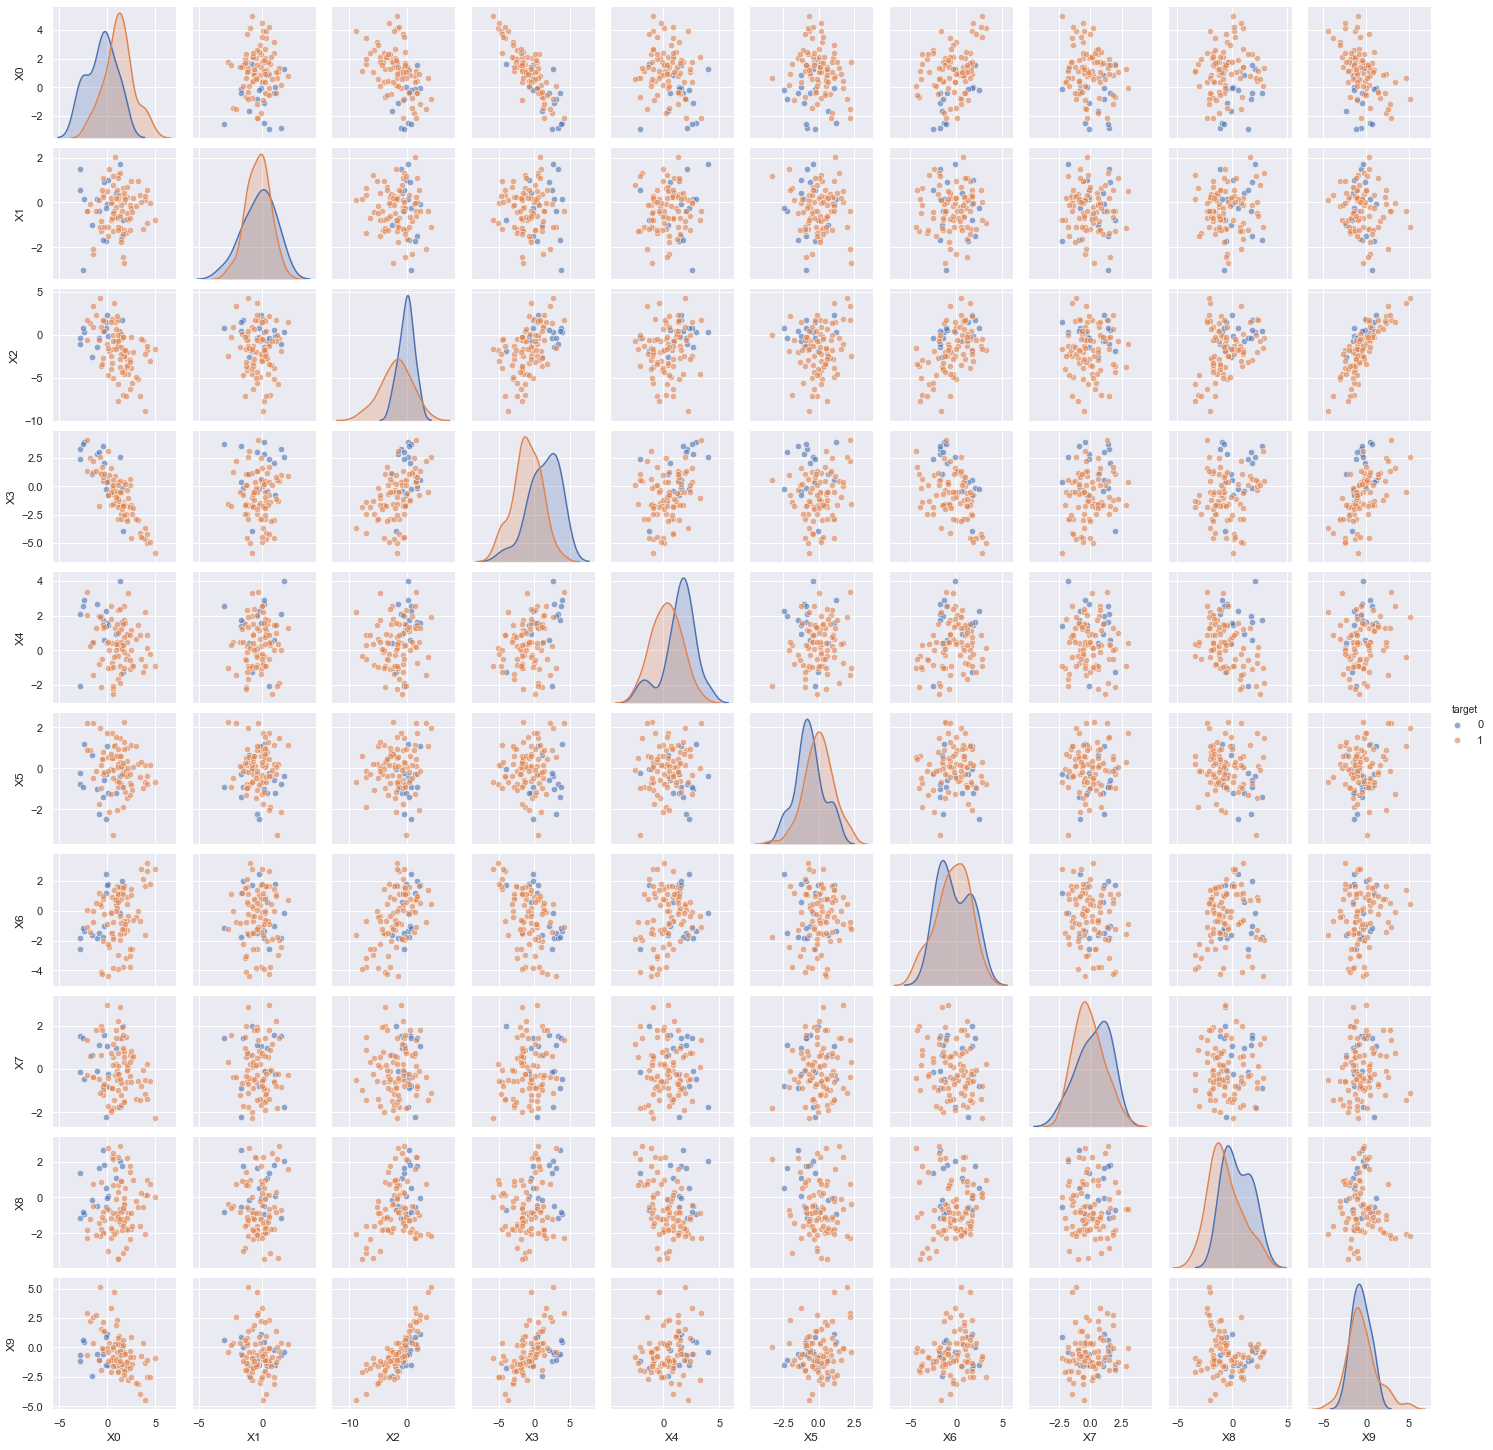

In [10]:
X, y = make_classification(n_samples=1000, 
                           n_features=10, n_informative=5, n_redundant=2, 
                           n_classes=2, n_clusters_per_class=3, 
                           weights=[0.3], random_state=42)


cols = ["X"+str(i) for i in range(10)]
df_10 = pd.DataFrame(X, columns=cols)
target = 'target'
df_10[target] = y

samp = df_10.sample(100)

sns.pairplot(samp, vars=cols, 
             hue=target, diag_kind='kde', 
             plot_kws={'alpha': 0.6, 's': 40},
             height=2)
plt.show()

In [21]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
X = pca.fit_transform(df_10.drop(columns='target'))
pca.explained_variance_ratio_

array([0.41662204, 0.20953286])

In [30]:
x_df = pd.DataFrame(X,columns=['pc1','pc2'])
x_df['target']=df_10.target
x_df

,pc1,pc2,target
0,-1.606736,-1.781295,1
1,-3.365747,1.048509,0
2,-3.785223,1.237200,0
3,-1.524980,3.270712,0
4,-1.637031,-0.864215,0
...,...,...,...
995,-5.438021,-0.186829,1
996,2.972452,-0.225221,1
997,1.924815,1.231614,0
998,-1.936813,-0.034818,1


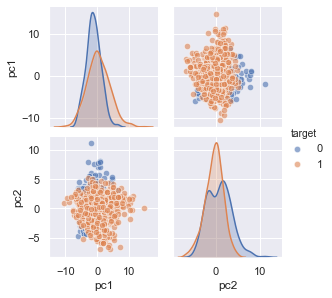

In [31]:
sns.pairplot(x_df, vars=['pc1','pc2'], 
             hue=target, diag_kind='kde', 
             plot_kws={'alpha': 0.6, 's': 40},
             height=2)
plt.show()

## Tuned Forest-Scorecard Baseline

In [32]:
used_cols = [c for c in df_10.columns.tolist() if c not in [target]]
X, y = df_10[used_cols], df_10[target]

rf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                            criterion='entropy', max_depth=10, max_features=5,
                            min_samples_leaf=3, min_samples_split=5,
                            n_estimators=71, n_jobs=-1, random_state=42)

encoder = ForestEncoder(rf)
clf = LogisticRegression(class_weight='balanced')
pipe = make_pipeline(encoder, clf)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())
#metric to beat

0.9561904761904761 +/- 0.012523221061677291


In [33]:
scores

array([0.96404762, 0.96452381, 0.9477381 , 0.93571429, 0.96892857])

# Gradient Boosting

## Gradient Boosting with SciKit-Learn

In [12]:
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

from sklearn.svm import SVC

### Simple Model Baselines

#### Support Vector Machine

In [13]:
used_cols = [c for c in df_10.columns.tolist() if c not in [target]]
X, y = df_10[used_cols], df_10[target]

svm = SVC(probability=True, class_weight='balanced', random_state=42)

scores = cross_val_score(svm, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9421666666666667 +/- 0.0166127358733376


#### Random Forest

In [14]:
used_cols = [c for c in df_10.columns.tolist() if c not in [target]]
X, y = df_10[used_cols], df_10[target]

scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9502142857142857 +/- 0.012957588238963376


### Boosted Models

#### AdaBoosted SVM

In [15]:
clf = AdaBoostClassifier(svm, n_estimators=50, 
                         learning_rate=0.1, random_state=42)

scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9560238095238095 +/- 0.008178354817953573


#### Gradient Boosted Trees

In [35]:
clf = GradientBoostingClassifier(n_estimators=2000,
                                 learning_rate=0.1, random_state=42, 
                                 subsample=0.9, max_depth=5, max_features=5,
                                 min_samples_leaf=2, min_samples_split=5,
                                 validation_fraction=0.20, # use 20% of the data as hold-out for early stopping
                                 n_iter_no_change=50, # allowed to go 50 iterations without improvement to hold-out score
                                 verbose=0)

scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9406666666666667 +/- 0.01583263514393315


In [36]:
clf.fit(X, y)
clf.feature_importances_
#coefficients have direction and importance
#this is just importance
#cant tell which contributes to what class
#below X0 featured in 25% of splits

array([0.25255642, 0.01910174, 0.07857331, 0.11529893, 0.10976982,
       0.01387413, 0.07455068, 0.02225142, 0.18214725, 0.1318763 ])

**Note**: We will need to tune this to beat the performance of the tuned forest.

#### Histogram-Gradient Boosted Trees (akin to the LightGBM algorithm)

In [18]:
clf = HistGradientBoostingClassifier(loss='binary_crossentropy', random_state=42, 
                                     learning_rate=0.05, max_iter=150, 
                                     max_leaf_nodes=2**5-1, max_bins=100, l2_regularization=0.5)

scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9507380952380953 +/- 0.01617811152505157


#### NGBoost

In [37]:
!pip install ngboost

     |████████████████████████████████| 340 kB 4.4 MB/s eta 0:00:01
  Created wheel for autograd: filename=autograd-1.3-py3-none-any.whl size=47990 sha256=91d31e8168aac4415fc967b791339fc599172d47ced80f2cc09e95e434242b21
  Stored in directory: /Users/kcahlers/Library/Caches/pip/wheels/ef/32/31/0e87227cd0ca1d99ad51fbe4b54c6fa02afccf7e483d045e04
Successfully built autograd


In [38]:
from ngboost import NGBClassifier
from ngboost.distns import Bernoulli
from ngboost.learners import default_tree_learner
from ngboost.scores import MLE

In [39]:
ngb = NGBClassifier(Base=default_tree_learner, 
                    Dist=Bernoulli, 
                    Score=MLE, verbose=False)

scores = cross_val_score(ngb, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9113460747785593 +/- 0.021234392738708033


In [40]:
ngb

NGBClassifier(random_state=RandomState(MT19937) at 0x7FE553AA7490,
              verbose=False)

**Note**: We need to tune the default hyper-parameters to improve upon this score.

# Surrogate Modeling

We can take a "black-box" model such as a GBM and make it more interpretable by approximating with a simpler model like a DT.

## Original Model and Setup

In [2]:
!pip install xgboost

In [5]:
!brew install libomp

Updating Homebrew...
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
amp                        hasura-cli                 pandoc-include-code
asimov                     heksa                      po4a
awsweeper                  idris2                     pwncat
blogc                      inko                       python@3.7
buildozer                  jerryscript                rgf
carton                     jobber                     rqlite
choose-rust                k9s                        s2n
chrony                     kde-karchive               saltwater
cloudformation-cli         kde-kdoctools              skylighting
coconut                    kde-ki18n                  smlpkg
colfer                     kde-threadweaver           so
cpio                       kibana@6.8                 sonic
cpm                        latexindent                standardese
doctest                    libgnt                     termcolor
dosbox-stag


==> Downloading https://homebrew.bintray.com/bottles/libomp-10.0.0.catalina.bott
==> Downloading from https://d29vzk4ow07wi7.cloudfront.net/0ea757dbea7bf12141ef1
######################################################################## 100.0%
==> Pouring libomp-10.0.0.catalina.bottle.tar.gz
🍺  /usr/local/Cellar/libomp/10.0.0: 9 files, 1.3MB
==> `brew cleanup` has not been run in 30 days, running now...
Removing: /Users/kcahlers/Library/Caches/Homebrew/git--2.26.2_1.catalina.bottle.tar.gz... (18.3MB)
Removing: /Users/kcahlers/Library/Caches/Homebrew/Cask/db-browser-for-sqlite--3.11.2.dmg... (16MB)
Removing: /Users/kcahlers/Library/Logs/Homebrew/gettext... (64B)
Removing: /Users/kcahlers/Library/Logs/Homebrew/pcre2... (64B)
Removing: /Users/kcahlers/Library/Logs/Homebrew/git... (64B)


In [6]:
from xgboost import XGBClassifier
xgb = XGBClassifier(objective='binary:logistic', n_estimators = 2)

In [7]:
scores = cross_val_scores (xgb,X,y,cv=5, scoring = 'roc_auc')
print(scores.mean(), "+/-", scores.std())

NameError: name 'cross_val_scores' is not defined

In [47]:
used_cols = [c for c in df_10.columns.tolist() if c not in [target]]
X, y = df_10[used_cols], df_10[target]

# original model
clf = AdaBoostClassifier(svm, n_estimators=50, 
                         learning_rate=0.1, 
                         random_state=42)

# 45 - 45 - 10 Split : Train - Proxy - Hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, 
                                                    random_state=42, 
                                                    stratify=y)

X_train, X_proxy, y_train, y_proxy = train_test_split(X_train, y_train, test_size=0.50, 
                                                      random_state=42, 
                                                      stratify=y_train)

# fit the original model
clf.fit(X_train, y_train)

# score on hold-out set
y_pred = clf.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.9404761904761905

## Surrogate Model

In [48]:
# predicted probabilities on the "proxy" hold-out set
y_pred = clf.predict_proba(X_proxy)[:,1]

# surrogate / proxy - DT approximation of Original model
dt = DecisionTreeRegressor(max_leaf_nodes=2**4-1, random_state=42)
dt.fit(X_proxy, y_pred)

DecisionTreeRegressor(max_leaf_nodes=15, random_state=42)

In [49]:
y_pred = dt.predict(X_test)
roc_auc_score(y_test, y_pred)

0.8373809523809524

## Visualizing the Surrogate Model

/Users/kcahlers/Applications/anaconda3/lib/python3.7/site-packages/sklearn/tree/_export.py:185: FutureWarning: 'rotate' has no effect and is deprecated in 0.23. It will be removed in 0.25.
  FutureWarning)


[Text(147.47142857142856, 199.32, 'node #0\nX0 <= -0.768\nmse = 0.06\nsamples = 450\nvalue = 0.731'),
 Text(79.71428571428572, 163.07999999999998, 'node #1\nX9 <= 0.438\nmse = 0.087\nsamples = 92\nvalue = 0.506'),
 Text(47.82857142857143, 126.83999999999999, 'node #3\nX3 <= 1.086\nmse = 0.041\nsamples = 61\nvalue = 0.348'),
 Text(31.885714285714286, 90.6, 'node #15\nX4 <= -1.338\nmse = 0.049\nsamples = 24\nvalue = 0.463'),
 Text(15.942857142857143, 54.359999999999985, 'node #17\nmse = 0.005\nsamples = 4\nvalue = 0.789'),
 Text(47.82857142857143, 54.359999999999985, 'node #18\nmse = 0.032\nsamples = 20\nvalue = 0.398'),
 Text(63.77142857142857, 90.6, 'node #16\nmse = 0.023\nsamples = 37\nvalue = 0.273'),
 Text(111.6, 126.83999999999999, 'node #4\nX8 <= -1.155\nmse = 0.03\nsamples = 31\nvalue = 0.816'),
 Text(95.65714285714286, 90.6, 'node #21\nmse = 0.006\nsamples = 19\nvalue = 0.912'),
 Text(127.54285714285714, 90.6, 'node #22\nmse = 0.032\nsamples = 12\nvalue = 0.665'),
 Text(215.2285

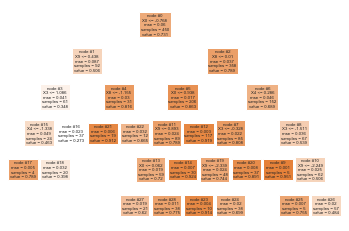

In [51]:
from sklearn.tree import plot_tree
plot_tree(dt, feature_names=used_cols, filled=True,
           node_ids=True, rotate=True)

In [52]:
from sklearn.tree import export_graphviz
print(export_graphviz(dt,feature_names=used_cols, filled=True,
           node_ids=True, rotate=True))

digraph Tree {
node [shape=box, style="filled", color="black"] ;
rankdir=LR ;
0 [label="node #0\nX0 <= -0.768\nmse = 0.06\nsamples = 450\nvalue = 0.731", fillcolor="#edaa79"] ;
1 [label="node #1\nX9 <= 0.438\nmse = 0.087\nsamples = 92\nvalue = 0.506", fillcolor="#f6d4bb"] ;
0 -> 1 [labeldistance=2.5, labelangle=-45, headlabel="True"] ;
3 [label="node #3\nX3 <= 1.086\nmse = 0.041\nsamples = 61\nvalue = 0.348", fillcolor="#fcf1e9"] ;
1 -> 3 ;
15 [label="node #15\nX4 <= -1.338\nmse = 0.049\nsamples = 24\nvalue = 0.463", fillcolor="#f8dcc7"] ;
3 -> 15 ;
17 [label="node #17\nmse = 0.005\nsamples = 4\nvalue = 0.789", fillcolor="#eb9f68"] ;
15 -> 17 ;
18 [label="node #18\nmse = 0.032\nsamples = 20\nvalue = 0.398", fillcolor="#fae8da"] ;
15 -> 18 ;
16 [label="node #16\nmse = 0.023\nsamples = 37\nvalue = 0.273", fillcolor="#ffffff"] ;
3 -> 16 ;
4 [label="node #4\nX8 <= -1.155\nmse = 0.03\nsamples = 31\nvalue = 0.816", fillcolor="#ea9a60"] ;
1 -> 4 ;
21 [label="node #21\nmse = 0.006\nsamples = 1

# References / Resources

* SciKit-Learn Implementations

    * https://scikit-learn.org/stable/modules/ensemble.html#adaboost

    * https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting

    * https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting

* Non-SciKit-Learn Implementations

    * https://github.com/catboost/catboost

    * https://github.com/microsoft/LightGBM

    * https://github.com/jhwjhw0123/Imbalance-XGBoost

    * https://github.com/dmlc/xgboost

    * https://github.com/stanfordmlgroup/ngboost

* Background

    * https://en.wikipedia.org/wiki/Gradient_boosting

    * https://explained.ai/gradient-boosting/index.html

    * https://en.wikipedia.org/wiki/AdaBoost

    * https://en.wikipedia.org/wiki/XGBoost

* Other

    * https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py

    * https://github.com/szilard/GBM-perf

    * https://github.com/talperetz/awesome-gradient-boosting#notebooks

    * https://nbviewer.jupyter.org/github/jphall663/interpretable_machine_learning_with_python/blob/master/dt_surrogate_loco.ipynb
    
    * https://github.com/limexp/xgbfir